In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import multibind as mb
import numpy as np
import pandas as pd
import torch
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/multibind/multibind/tl/prediction.py:116: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if model.kernels[position] is not 0:


Using device: cuda:0


In [4]:
mb.bindome.constants.ANNOTATIONS_DIRECTORY = '/mnt/c/Users/ignacio.ibarra/Dropbox/annotations'

In [5]:
adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir='../../atac_poisson_study/data/')
peak_ids = adata.var_names

In [6]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - 100
adata.var['summit.end'] = adata.var['summit'] + 100

In [7]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [8]:
adata.shape

(10246, 165434)

In [44]:
n_seqs = 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True)
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/mnt/c/Users/ignacio.ibarra/Dropbox/annotations
/tmp/tmpow5loryn
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmpow5loryn -fo /tmp/tmp_vh18wtr


In [45]:
!head /tmp/tmpmmggqwiw 

In [46]:
adata.shape

(10246, 100)

In [47]:
len(seqs)

100

In [48]:
# remove Ns
seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [49]:
next_data = pd.DataFrame.sparse.from_spmatrix(counts)


In [50]:
next_data['seq'] = [s[1] for s in seqs]

In [51]:
next_data

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,seq
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCTAACCCTAACCCTAACCCTAACCCTAACCCCTAACCCTAACCC...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACAACCCTAACCCTAACCCTAACAACCCTAACCCTAACCCTAACCC...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CGCAGAGAGGCGCGCCGCGCCGGCGCAGGCGCAGAGACACATGCTA...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ACTGGGGCCTGAGCTGCGTGGTGGGGAGAGAGTCTCTCCCCTGCCC...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CTTCTGAAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCTGTGTACGTGTGTCAAGCCTAGCCACCTCAGCTGCAGGGAGGCA...
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TGTGCTCAGGGGCAGCCCCCACGCACTCACAGAGTCCAGGATCTCA...
97,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CACGGACCTCTGGGCCTGGTCAAACAGGATCTGGGGGCAGAGGCGG...
98,1.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,ACGGACGTGCTCATGGGGACAGGGTGGGCCCTGGCAGAGGCCCCGA...


In [52]:
# next_data[next_data.columns[:-1]].sum(axis=1).sort_values(ascending=False)

In [53]:
next_data.head(1000).var(axis=1)

/tmp/ipykernel_3435/3781555156.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  next_data.head(1000).var(axis=1)


0     0.005533
1     0.011194
2     0.010443
3     0.016172
4     0.016230
        ...   
95    0.081181
96    0.036761
97    0.022701
98    0.302115
99    1.465769
Length: 100, dtype: float64

In [54]:
# next_data.var(axis=1)

In [55]:
var = []
for ri, r in next_data.iterrows():
    if ri % 10000 == 0:
        print(ri, next_data.shape)
    # print(ri, r.values[:-1], r.values[:-1].var())
    var.append(r.values[:-1].var())
    # break

0 (100, 10247)


In [56]:
next_data['var'] = var

In [57]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [58]:
top_var = next_data[['var']].sort_values('var', ascending=False).index[:1000]

In [59]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var).reset_index(drop=True)

In [60]:
next_data_sel.head()

,0,1,2,3,4,5,6,7,8,9,...,10238,10239,10240,10241,10242,10243,10244,10245,seq,var
0,0.0,3.0,0.0,4.0,3.0,1.0,5.0,0.0,1.0,2.0,...,0.0,0.0,2.0,0.0,0.0,1.0,3.0,1.0,CGCCCCGGCCCCGGCGCCAGGCCCCGCAGCTCCCAAAGAAAACTAC...,1.599187
1,1.0,0.0,4.0,2.0,2.0,8.0,6.0,2.0,4.0,1.0,...,0.0,1.0,1.0,2.0,1.0,5.0,1.0,3.0,GAGGCGGGGCCTGCCACGGCCGTCTCCGGGGACAGTCGGTGGAAAT...,1.465626
2,0.0,0.0,2.0,1.0,2.0,4.0,1.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,AACACCCGCGCCTCTAACGTCGCCAACGGCCCACCTCTATGGTGTC...,1.110850
3,1.0,3.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,...,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,GCGAACGGGCGCGACCTCACGGAGGGGACGCCGGCGCCACCATCTC...,0.986260
4,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,TTTTGTTTCTTCCGCTCACTCTGGGGCATGCCTCGGGAAAGGGAAA...,0.763797


In [61]:
# next_data_sel = next_data.copy().head(5000)
# next_data_sel = next_data_sel[[i for i in range(1000)] + ['seq']].head(5000)
# next_data_sel = next_data_sel[next_data_sel[next_data_sel.columns[:-1]].sum(axis=1) > 10]
# next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)
# next_data_sel

In [62]:
next_data_sel = next_data_sel[next_data_sel['seq'].str.len() == 200].reset_index(drop=True)

In [63]:
# next_data_sel.sum(axis=1)

In [64]:
del next_data_sel['var']

In [65]:
n_rounds = next_data_sel.shape[1] - 2
n_rounds

10245

In [66]:
next_data_sel['batch'] = 0
next_data_sel['batch'] = next_data_sel['batch'].astype(float)

In [67]:
dataset = mb.datasets.SelexDataset(next_data_sel, n_rounds=n_rounds, single_encoding_step=True)
train = tdata.DataLoader(dataset=dataset, batch_size=100, shuffle=True)
train_test = tdata.DataLoader(dataset=dataset, batch_size=1, shuffle=False)

In [68]:
w = 14
n_kernels = 3

In [69]:
model = mb.models.DinucSelex(use_dinuc=False, kernels=[0] + [w] * (n_kernels - 1),  n_rounds=n_rounds, enr_series=False).to(device)

In [70]:
for ki in range(n_kernels):
    mb.tl.update_grad(model, ki, ki == 0)

In [71]:
optimiser = topti.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
criterion = mb.tl.PoissonLoss()

In [72]:
loss = mb.tl.train_network(model, train, device, optimiser, criterion, num_epochs=500, early_stopping=5, log_each=1)

Epoch:  1, Loss: 0.288
Epoch:  2, Loss: 0.287
Epoch:  3, Loss: 0.287
Epoch:  4, Loss: 0.287
Epoch:  5, Loss: 0.287
Epoch:  6, Loss: 0.287
Epoch:  7, Loss: 0.287
Epoch:  8, Loss: 0.287


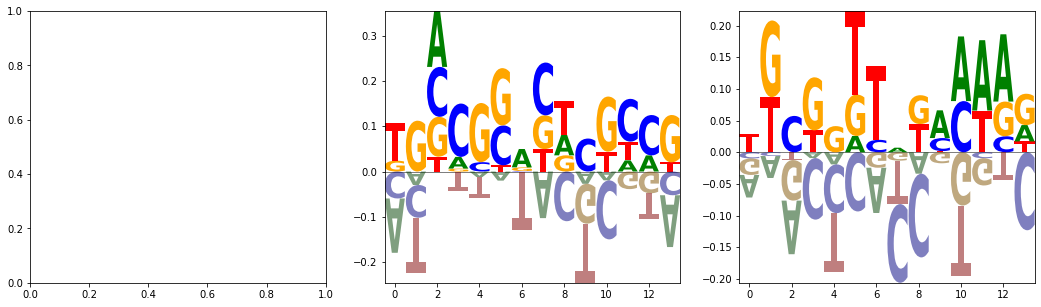

In [73]:
mb.pl.conv_mono(model)